In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gpplot as gpp
from poola import core as pool
import anchors

import core_functions as fns

gpp.set_aesthetics(palette='Set2')

In [3]:
def run_guide_residuals(lfc_df, paired_lfc_cols=[]):
    '''
    Calls get_guide_residuals function from anchors package to calculate guide-level residual z-scores
    Inputs:
    1. lfc_df: data frame with log-fold changes (relative to pDNA)
    2. paired_lfc_cols: grouped list of initial populations and corresponding resistant populations 
    
    '''
    lfc_df = lfc_df.drop_duplicates()
    if not paired_lfc_cols:
        paired_lfc_cols = fns.pair_cols(lfc_df)[1] #get lfc pairs 
    modified = []
    unperturbed = []
    #reference_df: column1 = modifier condition, column2 = unperturbed column
    ref_df = pd.DataFrame(columns=['modified', 'unperturbed'])
    row = 0 #row index for reference df 
    for pair in paired_lfc_cols:
        #number of resistant pops in pair = len(pair)-1
        res_idx = 1 
        #if multiple resistant populations, iterate 
        while res_idx < len(pair): 
            ref_df.loc[row, 'modified'] = pair[res_idx]
            ref_df.loc[row, 'unperturbed'] = pair[0]
            res_idx +=1 
            row +=1
    
    print(ref_df)
    #input lfc_df, reference_df 
    #guide-level
    residuals_lfcs, all_model_info, model_fit_plots = anchors.get_guide_residuals(lfc_df, ref_df)
    return residuals_lfcs, all_model_info, model_fit_plots


def select_top_ranks(df, rank = 5): #pick top ranks from each column of df with ranks, rank = top rank threshold (e.g. 5 if top 5)
    '''
    Inputs: 
    1. df: Dataframe with columns "Gene Symbol" and data used to rank 
    2. rank: top number of rows to select 
    Outputs:
    1. final_top_rank_df: Data frame with top ranked rows 
    '''
    rank_cols = df.columns.to_list()[1:]
    prev_top_rank_rows = pd.DataFrame(columns = df.columns)
    final_top_rank_df = pd.DataFrame() #for final list
    for col in rank_cols:
        #top_rank_rows = df.copy().loc[lambda df: df[col] <= rank, :] #pick rows with rank <= 5
        top_rank_rows = df.copy().nlargest(rank, col)
        top_rank_df = pd.concat([prev_top_rank_rows, top_rank_rows]) #concat with rows selected from previous column
        prev_top_rank_rows = top_rank_df #set combined list as previous

    final_top_rank_df = prev_top_rank_rows.drop_duplicates(subset = ['Gene Symbol']) #drop duplicate gene rows
    return final_top_rank_df

## Data summary
 

In [5]:
reads_nopDNA_1 = pd.read_csv('../../../Data/Reads/Goujon/Calu3/Secondary_Library/counts-JD_GPP2725_Goujon_Plate2.txt', sep='\t')
reads_nopDNA_1 = reads_nopDNA_1.copy().drop('Construct IDs', axis=1)
reads_nopDNA_2 = pd.read_csv('../../../Data/Reads/Goujon/Calu3/Secondary_Library/counts-JD_GPP2772_Goujon_20210726_P1_CP1663.txt', sep='\t')
reads_nopDNA_2 = reads_nopDNA_2.copy().drop('Construct IDs', axis=1)

reads_nopDNA = pd.merge(reads_nopDNA_1, reads_nopDNA_2, on = ['Construct Barcode'], how = 'outer')
reads_nopDNA

pDNA_reads_all = pd.read_csv('../../../Data/Reads/Goujon/Calu3/Secondary_Library/counts-LS20210325_A01_AAHG03_XPR502_G0_CP1663_M-AM39.txt', sep='\t')
pDNA_reads_all
pDNA_reads = pDNA_reads_all[['Construct Barcode','A01_AAHG03_XPR502_G0_CP1663_M-AM39']].copy()
pDNA_reads = pDNA_reads.rename(columns = {'A01_AAHG03_XPR502_G0_CP1663_M-AM39': 'pDNA'})
pDNA_reads

reads_all = pd.merge(pDNA_reads, reads_nopDNA, how = 'right', on='Construct Barcode')
empty_cols = [col for col in reads_all.columns if 'EMPTY' in col]
reads_all = reads_all.copy().drop(empty_cols, axis=1)

CP1663_cols = ['Construct Barcode', 'pDNA'] + [col for col in reads_all.columns if '1663' in col]

reads_plate_split = reads_all[CP1663_cols]

reads = reads_plate_split.copy()
reads = reads.drop(['Calu3-CP1663-resistant population screen #2.2_x', 'Calu3-CP1663-resistant population screen #2.2_y'], axis=1)
# Combine reads for resistant population screen #2.2
reads.loc[:,'Calu3-CP1663-resistant population screen #2.2'] = (reads_plate_split['Calu3-CP1663-resistant population screen #2.2_x'] + 
                                                          reads_plate_split['Calu3-CP1663-resistant population screen #2.2_y'])
# reads.loc[:,'Calu3-CP1663-resistant population screen #2.2'] = resistant_2_2_combined_reads
reads

,Construct Barcode,pDNA,Calu3-CP1663-intitial population screen #1,Calu3-CP1663-resistant population screen #1,Calu3-CP1663-intitial population screen #2,Calu3-CP1663-resistant population screen #2.1,Calu3-CP1663-resistant population screen #2.2
0,AAAAAAAAAAAAAATTGGCC,11,1462,1906,1383,181,539
1,AAAAAAAAATTGGCCAGGCG,28,5222,4361,4766,698,2537
2,AAAAAAAGTTGTGCGAGCGA,45,8386,6986,8914,1610,4894
3,AAAAAAGAAAATAAGTTCCC,28,2934,1978,3206,698,1604
4,AAAAAAGTTGTGCGAGCGAC,70,9587,11046,9297,1257,3663
...,...,...,...,...,...,...,...
4996,TTTGGAGTGATATTCGAACA,51,8646,8613,10193,1878,4502
4997,TTTGGCAGTCTATTACGGTA,62,14316,14195,11947,4374,8506
4998,TTTGGTGTGGCCGTCGCGCA,30,4487,6183,4641,2453,5658
4999,TTTGTGGGCCATTTAATTCA,52,12855,11054,17807,4909,9353


In [6]:
# Gene Annotations
chip = pd.read_csv('../../../Data/Interim/Goujon/Calu3/Secondary_Library/CP1663_GRCh38_NCBI_strict_gene_20210707.chip', sep='\t')
chip = chip.rename(columns={'Barcode Sequence':'Construct Barcode'})
chip_reads = pd.merge(chip[['Construct Barcode', 'Gene Symbol']], reads, on = ['Construct Barcode'], how = 'right')
chip_reads


,Construct Barcode,Gene Symbol,pDNA,Calu3-CP1663-intitial population screen #1,Calu3-CP1663-resistant population screen #1,Calu3-CP1663-intitial population screen #2,Calu3-CP1663-resistant population screen #2.1,Calu3-CP1663-resistant population screen #2.2
0,AAAAAAAAAAAAAATTGGCC,IQCN,11,1462,1906,1383,181,539
1,AAAAAAAAAAAAAATTGGCC,LOC101929974,11,1462,1906,1383,181,539
2,AAAAAAAAATTGGCCAGGCG,IQCN,28,5222,4361,4766,698,2537
3,AAAAAAAGTTGTGCGAGCGA,GDI2,45,8386,6986,8914,1610,4894
4,AAAAAAGAAAATAAGTTCCC,DBR1,28,2934,1978,3206,698,1604
...,...,...,...,...,...,...,...,...
5847,TTTGGAGTGATATTCGAACA,ONE_INTERGENIC_SITE_499,51,8646,8613,10193,1878,4502
5848,TTTGGCAGTCTATTACGGTA,ONE_INTERGENIC_SITE_500,62,14316,14195,11947,4374,8506
5849,TTTGGTGTGGCCGTCGCGCA,LYN,30,4487,6183,4641,2453,5658
5850,TTTGTGGGCCATTTAATTCA,EEF1B2,52,12855,11054,17807,4909,9353


In [7]:
#Calculate lognorm
cols = chip_reads.columns[2:].to_list() #reads columns = start at 3rd column
lognorms = fns.get_lognorm(chip_reads.dropna(), cols = cols)
col_list = []

for col in lognorms.columns:
    if 'intitial'in col:
        new_col = col.replace('intitial', 'initial')
        col_list.append(new_col)
    else:
        col_list.append(col)

lognorms.columns = col_list
lognorms

,Construct Barcode,Gene Symbol,pDNA_lognorm,Calu3-CP1663-initial population screen #1_lognorm,Calu3-CP1663-resistant population screen #1_lognorm,Calu3-CP1663-initial population screen #2_lognorm,Calu3-CP1663-resistant population screen #2.1_lognorm,Calu3-CP1663-resistant population screen #2.2_lognorm
0,AAAAAAAAAAAAAATTGGCC,IQCN,5.731072,5.074491,5.509078,5.008518,3.877976,4.522267
1,AAAAAAAAAAAAAATTGGCC,LOC101929974,5.731072,5.074491,5.509078,5.008518,3.877976,4.522267
2,AAAAAAAAATTGGCCAGGCG,IQCN,7.062410,6.879988,6.685244,6.761326,5.750637,6.706723
3,AAAAAAAGTTGTGCGAGCGA,GDI2,7.742824,7.558739,7.359774,7.658419,6.941140,7.647946
4,AAAAAAGAAAATAAGTTCCC,DBR1,7.062410,6.057774,5.561419,6.195778,5.750637,6.053285
...,...,...,...,...,...,...,...,...
5847,TTTGGAGTGATATTCGAACA,ONE_INTERGENIC_SITE_499,7.922604,7.602559,7.660163,7.850956,7.161600,7.528124
5848,TTTGGCAGTCTATTACGGTA,ONE_INTERGENIC_SITE_500,8.203320,8.327140,8.378151,8.079108,8.375594,8.442355
5849,TTTGGTGTGGCCGTCGCGCA,LYN,7.161226,6.663141,7.184755,6.723341,7.544586,7.856252
5850,TTTGTGGGCCATTTAATTCA,EEF1B2,7.950504,8.172351,8.018568,8.653147,8.541597,8.578928


## Quality Control
### Population Distributions

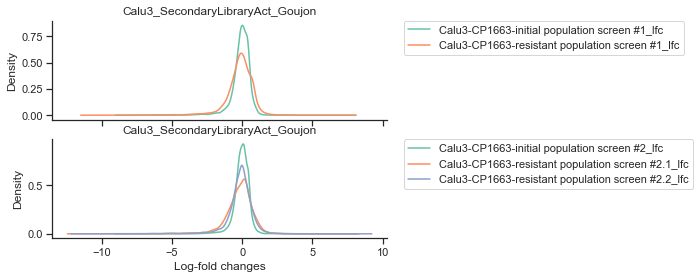

In [8]:
#Calculate log-fold change relative to pDNA
target_cols = list(lognorms.columns[3:])
pDNA_lfc = fns.calculate_lfc(lognorms,target_cols)
pDNA_lfc
pair1 = list(pDNA_lfc.columns[2:4])
pair2 = list(pDNA_lfc.columns[-3:])
paired_cols = (True, [pair1, pair2])
#Plot population distributions of log-fold changes 
fns.lfc_dist_plot(pDNA_lfc, paired_cols=paired_cols, filename = 'Calu3_SecondaryLibraryAct_Goujon')


### Distributions of control sets 

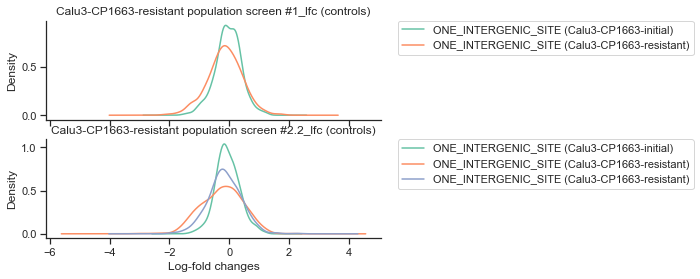

In [9]:
fns.control_dist_plot(pDNA_lfc, paired_cols=paired_cols, control_name=['ONE_INTERGENIC_SITE'], filename = 'Calu3_SecondaryLibraryAct_Goujon')


### ROC_AUC

Text(0, 0.5, 'True Positive Rate (essential)')

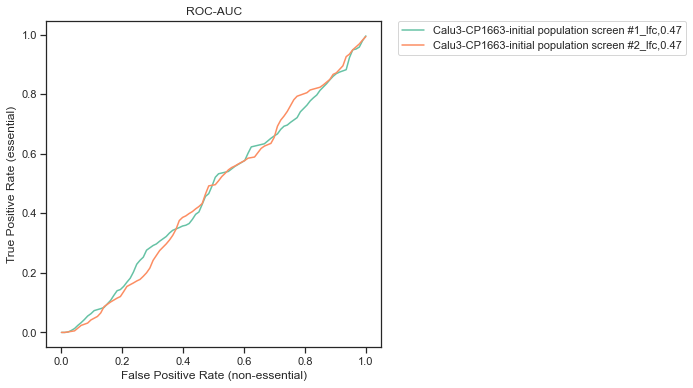

In [10]:
ess_genes, non_ess_genes = fns.get_gene_sets()
initial_cols = [col for col in pDNA_lfc.columns if 'initial' in col]

tp_genes = ess_genes.loc[:, 'Gene Symbol'].to_list()

fp_genes = non_ess_genes.loc[:, 'Gene Symbol'].to_list()

initial_roc_dict = {}
intial_roc_auc_dict = {}
for col in initial_cols:
    roc_auc, roc_df = pool.get_roc_aucs(pDNA_lfc, tp_genes, fp_genes, gene_col = 'Gene Symbol', score_col=col)
    initial_roc_dict[col] = roc_df
    intial_roc_auc_dict[col] = roc_auc

fig,ax=plt.subplots(figsize=(6,6))

for key, df in initial_roc_dict.items():
    roc_auc = intial_roc_auc_dict[key]
    ax=sns.lineplot(data=df, x='fpr',y='tpr', ci=None, label = key+',' + str(round(roc_auc,2)))

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('ROC-AUC')
plt.xlabel('False Positive Rate (non-essential)')
plt.ylabel('True Positive Rate (essential)')


## Gene level analysis

### Residual z-scores

In [11]:
lfc_df = pDNA_lfc.drop('Gene Symbol', axis = 1)
lfc_df

,Construct Barcode,Calu3-CP1663-initial population screen #1_lfc,Calu3-CP1663-resistant population screen #1_lfc,Calu3-CP1663-initial population screen #2_lfc,Calu3-CP1663-resistant population screen #2.1_lfc,Calu3-CP1663-resistant population screen #2.2_lfc
0,AAAAAAAAAAAAAATTGGCC,-0.656581,-0.221994,-0.722554,-1.853096,-1.208805
1,AAAAAAAAAAAAAATTGGCC,-0.656581,-0.221994,-0.722554,-1.853096,-1.208805
2,AAAAAAAAATTGGCCAGGCG,-0.182422,-0.377166,-0.301083,-1.311773,-0.355687
3,AAAAAAAGTTGTGCGAGCGA,-0.184085,-0.383050,-0.084406,-0.801685,-0.094878
4,AAAAAAGAAAATAAGTTCCC,-1.004635,-1.500991,-0.866631,-1.311773,-1.009125
...,...,...,...,...,...,...
5847,TTTGGAGTGATATTCGAACA,-0.320045,-0.262441,-0.071648,-0.761004,-0.394480
5848,TTTGGCAGTCTATTACGGTA,0.123820,0.174831,-0.124212,0.172275,0.239035
5849,TTTGGTGTGGCCGTCGCGCA,-0.498084,0.023529,-0.437884,0.383360,0.695027
5850,TTTGTGGGCCATTTAATTCA,0.221847,0.068064,0.702643,0.591093,0.628424


In [12]:
# run_guide_residuals(lfc_df.drop_duplicates(), cols)
residuals_lfcs, all_model_info, model_fit_plots = run_guide_residuals(lfc_df, paired_lfc_cols=paired_cols[1])
residuals_lfcs


                                            modified  \
0    Calu3-CP1663-resistant population screen #1_lfc   
1  Calu3-CP1663-resistant population screen #2.1_lfc   
2  Calu3-CP1663-resistant population screen #2.2_lfc   

                                     unperturbed  
0  Calu3-CP1663-initial population screen #1_lfc  
1  Calu3-CP1663-initial population screen #2_lfc  
2  Calu3-CP1663-initial population screen #2_lfc  


,Construct Barcode,condition,residual,residual_z,unperturbed,lfc,lfc_reference
0,AAAAAAAAAAAAAATTGGCC,Calu3-CP1663-resistant population screen #1_lfc,0.705333,1.314150,Calu3-CP1663-initial population screen #1_lfc,-0.221994,-0.656581
1,AAAAAAAAATTGGCCAGGCG,Calu3-CP1663-resistant population screen #1_lfc,-0.052951,-0.098656,Calu3-CP1663-initial population screen #1_lfc,-0.377166,-0.182422
2,AAAAAAAGTTGTGCGAGCGA,Calu3-CP1663-resistant population screen #1_lfc,-0.056754,-0.105742,Calu3-CP1663-initial population screen #1_lfc,-0.383050,-0.184085
3,AAAAAAGAAAATAAGTTCCC,Calu3-CP1663-resistant population screen #1_lfc,-0.119176,-0.222045,Calu3-CP1663-initial population screen #1_lfc,-1.500991,-1.004635
4,AAAAAAGTTGTGCGAGCGAC,Calu3-CP1663-resistant population screen #1_lfc,0.528786,0.985214,Calu3-CP1663-initial population screen #1_lfc,-0.360319,-0.626970
...,...,...,...,...,...,...,...
14998,TTTGGTGTGGCCGTCGCGCA,Calu3-CP1663-resistant population screen #2.2_lfc,1.250433,1.976938,Calu3-CP1663-initial population screen #2_lfc,0.695027,-0.437884
14999,TTTGTGGGCCATTTAATTCA,Calu3-CP1663-resistant population screen #2.1_lfc,-0.109707,-0.155693,Calu3-CP1663-initial population screen #2_lfc,0.591093,0.702643
15000,TTTGTGGGCCATTTAATTCA,Calu3-CP1663-resistant population screen #2.2_lfc,-0.032196,-0.050903,Calu3-CP1663-initial population screen #2_lfc,0.628424,0.702643
15001,TTTGTTTAAATAGCACTACA,Calu3-CP1663-resistant population screen #2.1_lfc,-0.752439,-1.067840,Calu3-CP1663-initial population screen #2_lfc,-1.293552,-0.321332


In [13]:
guide_mapping = pool.group_pseudogenes(chip[['Construct Barcode', 'Gene Symbol']], pseudogene_size=10, gene_col='Gene Symbol', control_regex=['ONE_INTERGENIC_SITE'])
guide_mapping

,Construct Barcode,Gene Symbol
0,AAAAAAAAAAAAAATTGGCC,IQCN
1,AAAAAAAAAAAAAATTGGCC,LOC101929974
2,AAAAAAAAATTGGCCAGGCG,IQCN
3,AAAAAAAGTTGTGCGAGCGA,GDI2
4,AAAAAAGAAAATAAGTTCCC,DBR1
...,...,...
5847,TTTGGAGTGATATTCGAACA,ONE_INTERGENIC_SITE_10
5848,TTTGGCAGTCTATTACGGTA,ONE_INTERGENIC_SITE_43
5849,TTTGGTGTGGCCGTCGCGCA,LYN
5850,TTTGTGGGCCATTTAATTCA,EEF1B2


In [14]:
gene_residuals = anchors.get_gene_residuals(residuals_lfcs.drop_duplicates(), guide_mapping)
gene_residuals

,condition,Gene Symbol,guides,avg_lfc,avg_lfc_reference,residual_zscore,p_value,fdr_bh
0,Calu3-CP1663-resistant population screen #1_lfc,ABHD17B,1,-0.305018,-0.036098,-0.303096,7.618164e-01,9.307246e-01
1,Calu3-CP1663-resistant population screen #1_lfc,ABRACL,10,0.082891,0.178900,-0.129491,8.969695e-01,9.752224e-01
2,Calu3-CP1663-resistant population screen #1_lfc,ACADSB,20,-0.142713,-0.121420,0.911007,3.622919e-01,7.636308e-01
3,Calu3-CP1663-resistant population screen #1_lfc,ACE,10,0.248759,0.113418,1.327455,1.843583e-01,7.636308e-01
4,Calu3-CP1663-resistant population screen #1_lfc,ACE2,10,-4.150156,-0.012840,-23.726590,1.917193e-124,1.572098e-121
...,...,...,...,...,...,...,...,...
2455,Calu3-CP1663-resistant population screen #2.2_lfc,ZNF626,1,0.446312,0.594455,-0.157397,8.749324e-01,9.700078e-01
2456,Calu3-CP1663-resistant population screen #2.2_lfc,ZNF703,10,-0.008235,-0.058939,0.627325,5.304463e-01,7.995699e-01
2457,Calu3-CP1663-resistant population screen #2.2_lfc,ZNF780A,10,-0.044614,0.015065,0.095698,9.237608e-01,9.758348e-01
2458,Calu3-CP1663-resistant population screen #2.2_lfc,ZNF805,10,-0.118506,-0.096297,0.280327,7.792263e-01,9.368996e-01


In [15]:
gene_residual_sheet = fns.format_gene_residuals(gene_residuals, guide_min = 8, guide_max = 11, ascending=True)

guide_residual_sheet = pd.merge(guide_mapping, residuals_lfcs.drop_duplicates(), on = 'Construct Barcode', how = 'inner')
guide_residual_sheet

['Calu3-CP1663-resistant population screen #2.1_lfc', 'Calu3-CP1663-resistant population screen #1_lfc', 'Calu3-CP1663-resistant population screen #2.2_lfc']
Calu3-CP1663-resistant population screen #2.1_lfc
Calu3-CP1663-resistant population screen #1_lfc
Calu3-CP1663-resistant population screen #2.2_lfc


,Construct Barcode,Gene Symbol,condition,residual,residual_z,unperturbed,lfc,lfc_reference
0,AAAAAAAAAAAAAATTGGCC,IQCN,Calu3-CP1663-resistant population screen #1_lfc,0.705333,1.314150,Calu3-CP1663-initial population screen #1_lfc,-0.221994,-0.656581
1,AAAAAAAAAAAAAATTGGCC,IQCN,Calu3-CP1663-resistant population screen #2.1_lfc,-0.732383,-1.039378,Calu3-CP1663-initial population screen #2_lfc,-1.853096,-0.722554
2,AAAAAAAAAAAAAATTGGCC,IQCN,Calu3-CP1663-resistant population screen #2.2_lfc,-0.261714,-0.413771,Calu3-CP1663-initial population screen #2_lfc,-1.208805,-0.722554
3,AAAAAAAAAAAAAATTGGCC,LOC101929974,Calu3-CP1663-resistant population screen #1_lfc,0.705333,1.314150,Calu3-CP1663-initial population screen #1_lfc,-0.221994,-0.656581
4,AAAAAAAAAAAAAATTGGCC,LOC101929974,Calu3-CP1663-resistant population screen #2.1_lfc,-0.732383,-1.039378,Calu3-CP1663-initial population screen #2_lfc,-1.853096,-0.722554
...,...,...,...,...,...,...,...,...
17551,TTTGTGGGCCATTTAATTCA,EEF1B2,Calu3-CP1663-resistant population screen #2.1_lfc,-0.109707,-0.155693,Calu3-CP1663-initial population screen #2_lfc,0.591093,0.702643
17552,TTTGTGGGCCATTTAATTCA,EEF1B2,Calu3-CP1663-resistant population screen #2.2_lfc,-0.032196,-0.050903,Calu3-CP1663-initial population screen #2_lfc,0.628424,0.702643
17553,TTTGTTTAAATAGCACTACA,OR8K5,Calu3-CP1663-resistant population screen #1_lfc,-0.067152,-0.125114,Calu3-CP1663-initial population screen #1_lfc,-0.367897,-0.163650
17554,TTTGTTTAAATAGCACTACA,OR8K5,Calu3-CP1663-resistant population screen #2.1_lfc,-0.752439,-1.067840,Calu3-CP1663-initial population screen #2_lfc,-1.293552,-0.321332


In [16]:
with pd.ExcelWriter('../../../Data/Processed/GEO_submission_v2/SecondaryLibrary/Calu3_SecondaryLibraryAct_Goujon.xlsx') as writer:  
    gene_residual_sheet.to_excel(writer, sheet_name='Calu3_avg_zscore', index =False)
    reads.to_excel(writer, sheet_name='Calu3_genomewide_reads', index =False)
    guide_mapping.to_excel(writer, sheet_name='Calu3_guide_mapping', index =False)

In [17]:
with pd.ExcelWriter('../../../Data/Processed/Individual_screens_v2/Calu3_SecondaryLibraryAct_Goujon.xlsx') as writer:  
    gene_residuals.to_excel(writer, sheet_name='condition_genomewide_zscore', index =False)
    guide_residual_sheet.to_excel(writer, sheet_name='guide-level_zscore', index =False)

### Comparison to Secondary Library KO

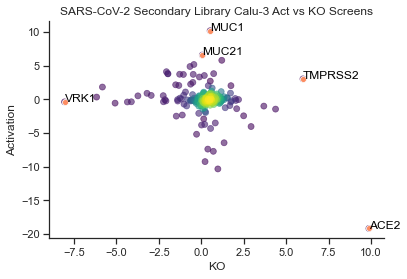

In [18]:
KO_gene_residual_sheet = pd.read_excel('../../../Data/Processed/GEO_submission_v2/SecondaryLibrary/Calu3_SecondaryLibraryKO_Goujon.xlsx')
secondary_library = pd.merge(KO_gene_residual_sheet, gene_residual_sheet, how = 'outer', on = 'Gene Symbol', suffixes=['_KO', '_Act'])

secondary_library_annot_df = select_top_ranks(secondary_library)
fig, ax = plt.subplots()
ax = gpp.point_densityplot(secondary_library.dropna(), x='residual_zscore_avg_KO', y='residual_zscore_avg_Act')
sns.scatterplot(data=secondary_library_annot_df.dropna(), x='residual_zscore_avg_KO', y='residual_zscore_avg_Act')
texts= []
for j, row in secondary_library_annot_df.dropna().iterrows():
    texts.append(ax.text(row['residual_zscore_avg_KO'], row['residual_zscore_avg_Act'], row['Gene Symbol'], 
                                  color = 'black'))
        # ensures text labels are non-overlapping
#     adjust_text(texts)
sns.despine()
plt.title('SARS-CoV-2 Secondary Library Calu-3 Act vs KO Screens')
plt.xlabel('KO')
plt.ylabel('Activation')
fig.savefig('../../../Figures/SecondaryLibrary_Calu3_ActvsKO.png', bbox_inches='tight')


In [19]:
screen1_df = gene_residuals[gene_residuals['condition'].str.contains('#1')]
screen2_df = gene_residuals[gene_residuals['condition'].str.contains('#2')]
screen2_df_avg = screen2_df[['condition','Gene Symbol', 'residual_zscore']].groupby('Gene Symbol', as_index=False).mean()

zscore_df = pd.merge(screen1_df[['condition','Gene Symbol', 'residual_zscore']], screen2_df_avg, on = 'Gene Symbol', how = 'outer', suffixes = ['_screen#1', '_screen#2']).sort_values(by='residual_zscore_screen#1')
# zscore_df = pd.concat([screen1_df[['condition','Gene Symbol', 'residual_zscore']], screen2_df[['condition','Gene Symbol', 'residual_zscore']]])
zscore_df


,condition,Gene Symbol,residual_zscore_screen#1,residual_zscore_screen#2
4,Calu3-CP1663-resistant population screen #1_lfc,ACE2,-23.726590,-16.943621
694,Calu3-CP1663-resistant population screen #1_lfc,SLC6A14,-8.072846,-11.499032
610,Calu3-CP1663-resistant population screen #1_lfc,RIPK3,-7.143177,-6.124609
474,Calu3-CP1663-resistant population screen #1_lfc,NFE2,-7.047814,-8.080523
748,Calu3-CP1663-resistant population screen #1_lfc,TP73,-5.860990,-4.866210
...,...,...,...,...
626,Calu3-CP1663-resistant population screen #1_lfc,RNF223,6.516487,5.803444
597,Calu3-CP1663-resistant population screen #1_lfc,RAI2,7.249786,6.202513
458,Calu3-CP1663-resistant population screen #1_lfc,MUC1,8.861599,10.864564
168,Calu3-CP1663-resistant population screen #1_lfc,ESX1,9.479970,10.420128


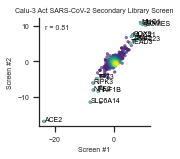

In [20]:
# Screen 2 vs Screen 1

fig, ax = plt.subplots(figsize = (2, 2))
ax = gpp.point_densityplot(zscore_df, 'residual_zscore_screen#1', 'residual_zscore_screen#2', s=6)
ax = gpp.add_correlation(zscore_df, 'residual_zscore_screen#1', 'residual_zscore_screen#2', fontsize=7)

top_ranked_screen1 = zscore_df.nsmallest(10, 'residual_zscore_screen#1')
top_ranked_screen2 = zscore_df.nsmallest(10, 'residual_zscore_screen#2')
bottom_ranked_screen1 = zscore_df.nlargest(10, 'residual_zscore_screen#1')
bottom_ranked_screen2 = zscore_df.nlargest(10, 'residual_zscore_screen#2')

screen1_ranked = pd.concat([top_ranked_screen1, bottom_ranked_screen1])
screen2_ranked = pd.concat([top_ranked_screen2, bottom_ranked_screen2])

# Annotate common hits
common_ranked = pd.merge(screen1_ranked, screen2_ranked, on = ['Gene Symbol', 'residual_zscore_screen#1', 'residual_zscore_screen#2'], how = 'inner')
common_ranked

sns.scatterplot(data=common_ranked, x='residual_zscore_screen#1', y='residual_zscore_screen#2', color = sns.color_palette('Set2')[0], edgecolor=None, s=6)

texts= []
for j, row in common_ranked.iterrows():
    texts.append(ax.text(row['residual_zscore_screen#1']+0.25, row['residual_zscore_screen#2'], row['Gene Symbol'], fontsize=7,
                                  color = 'black'))
        # ensures text labels are non-overlapping
#     adjust_text(texts)

plt.title('Calu-3 Act SARS-CoV-2 Secondary Library Screen', fontsize=7)
plt.xlabel('Screen #1', fontsize=7)
plt.ylabel('Screen #2', fontsize=7)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
sns.despine()
gpp.savefig('../../../Figures/Scatterplots/Calu3_Act_Secondary_Screen1vs2_scatterplot.pdf', dpi=300)



In [21]:
with pd.ExcelWriter('../../../Data/Processed/Individual_screens_v2/Calu3_SecondaryLibraryAct_Goujon_indiv_screens.xlsx') as writer:  
    zscore_df.to_excel(writer, sheet_name='indiv_screen_zscore', index =False)
    gene_residuals.to_excel(writer, sheet_name='condition_genomewide_zscore', index =False)
    guide_residual_sheet.to_excel(writer, sheet_name='guide-level_zscore', index =False)